# Analysing Consumption

In [6]:
import pandas as pd
# import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

import datetime

In [23]:
X_train = pd.read_csv(
    '../provided_data_and_metric/X_train_6GWGSxz.csv',
)
X_train.set_index("time_step", inplace=True)

Y_train = pd.read_csv(
    '../provided_data_and_metric/y_train_2G60rOL.csv',
)
Y_train.set_index("time_step", inplace=True)

A few useful transformers:

In [24]:
class DataImputer(BaseEstimator, TransformerMixin):  

    def __init__(self):
        self.X = None

    def fit(self, x, y=None):
        self.days_to_drop = ["2013-10-27", "2013-10-28", "2013-12-18", "2013-12-19",
                             "2013-08-01", "2013-08-02", "2013-11-10", "2013-07-07",
                             "2013-09-07", "2013-03-30", "2013-07-14"]
        return self

    def transform(self, x, y=None):
        x.index = pd.to_datetime(x.index)     
        try:
            x.drop(['visibility', 'temperature', 'humidity', 'humidex',
                    'windchill', 'wind', 'pressure', 'Unnamed: 9'], axis=1, inplace=True)
            for day in self.days_to_drop:
                x.drop(x.loc[day].index, inplace=True)
        except KeyError as e:
            pass

        x = x.interpolate(method='linear').fillna(method='bfill')
        return x

In [25]:
class YImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, x, y=None):
        self.days_to_drop = ["2013-10-27", "2013-10-28", "2013-12-18", "2013-12-19",
                     "2013-08-01", "2013-08-02", "2013-11-10", "2013-07-07",
                     "2013-09-07", "2013-03-30", "2013-07-14"]
        return self
    
    def transform(self, x, y=None):
        x.index = pd.to_datetime(x.index)
        try:
#             x.drop(['kettle', 'TV', 'washing_machine'], axis=1, inplace=True)
            for day in self.days_to_drop:
                x.drop(x.loc[day].index, inplace=True)
        except KeyError as e:
            pass
        
        x = x.interpolate(method='linear').fillna(method='bfill')
        return x

Transforming the data:

In [26]:
di = DataImputer()
yi = YImputer()
di.fit(X_train)
yi.fit(Y_train)
X = di.transform(X_train)
y = yi.transform(Y_train)

In [33]:
X.head()

,consumption
time_step,
2013-03-17 00:01:00,550.4000
2013-03-17 00:02:00,548.6000
2013-03-17 00:03:00,549.3000
2013-03-17 00:04:00,549.3667
2013-03-17 00:05:00,548.8909


In [34]:
y.head()

,washing_machine,fridge_freezer,TV,kettle
time_step,,,,
2013-03-17 00:01:00,0.0,79.2000,7.0,0.0
2013-03-17 00:02:00,0.0,78.0000,7.0,0.0
2013-03-17 00:03:00,0.0,76.9000,7.0,0.0
2013-03-17 00:04:00,0.0,76.1111,7.0,0.0
2013-03-17 00:05:00,0.0,75.2727,7.0,0.0


## Looking for spikes in consumption

Kettle Consumption:

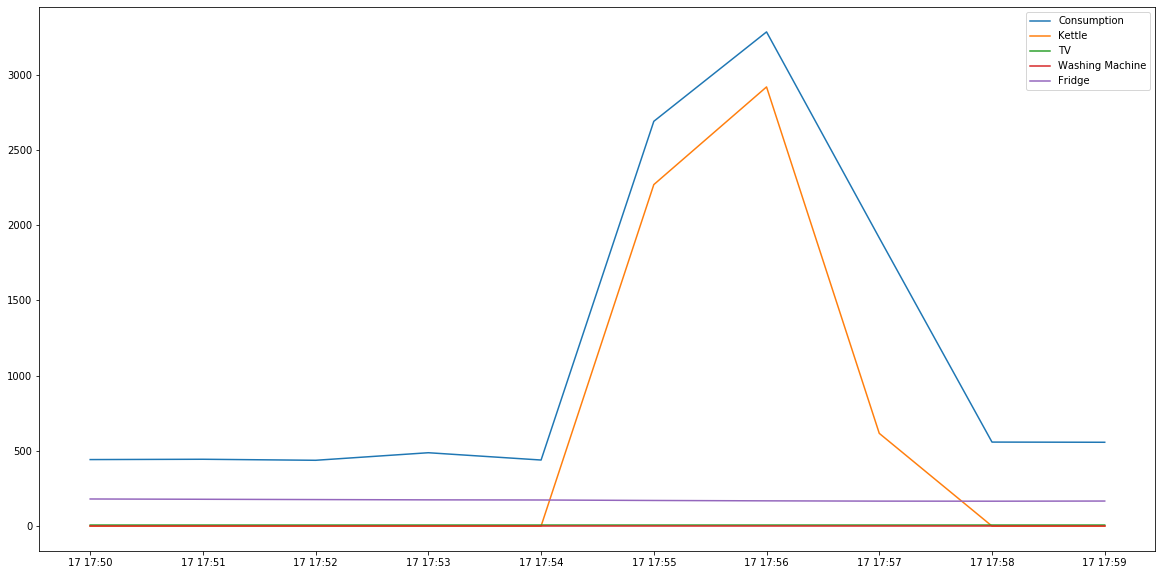

In [46]:
plt.figure(figsize=(20,10))
plt.plot(X.loc["2013-03-17 17:50:00":"2013-03-17 17:59:00",:], label="Consumption")
plt.plot(y.kettle.loc["2013-03-17 17:50:00":"2013-03-17 17:59:00",], label="Kettle")
plt.plot(y.TV.loc["2013-03-17 17:50:00":"2013-03-17 17:59:00",], label="TV")
plt.plot(y.washing_machine.loc["2013-03-17 17:50:00":"2013-03-17 17:59:00",], label="Washing Machine")
plt.plot(y.fridge_freezer.loc["2013-03-17 17:50:00":"2013-03-17 17:59:00",], label="Fridge")
plt.legend()

**Question:** can we detect spikes of consumption?

A [Bollinger Band®](https://www.investopedia.com/terms/b/bollingerbands.asp) is a technical analysis tool defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the security's price, but can be adjusted to user preferences. Bollinger Bands® were developed and copyrighted by famous technical trader John Bollinger.

This concept can be useful for us to detect departures from the mean.

In [206]:
rolling_mean = X.consumption.rolling(360).mean().fillna(method="bfill")

In [207]:
rolling_std = X.consumption.rolling(360).std().fillna(method="bfill")

In this case, given how kettle is very consumption heavy, we look for values above 4 std.

In [208]:
bollinger_bands = rolling_mean + 2*rolling_std

In [209]:
(bollinger_bands > 3000).sum()

37

In [210]:
anomalies = X.loc[X.consumption > bollinger_bands, :]

In [211]:
anomalies

,consumption
time_step,
2013-03-17 00:52:00,604.4273
2013-03-17 00:53:00,604.0000
2013-03-17 00:54:00,602.4040
2013-03-17 00:55:00,668.0111
2013-03-17 00:56:00,642.6060
...,...
2013-12-31 23:34:00,2304.7500
2013-12-31 23:41:00,2302.2222
2013-12-31 23:42:00,2326.8889


Look at the minimum:

In [216]:
min_anomalies = float(anomalies.min())
min_anomalies

161.2857

In [217]:
anomalies.loc[anomalies.consumption == min_anomalies, :]

,consumption
time_step,
2013-08-14 21:37:00,161.2857


We can get some values that are very low, especially in the morning.

In [218]:
X.loc[X.consumption == min_anomalies, :]

,consumption
time_step,
2013-04-09 09:22:00,161.2857
2013-05-06 04:40:00,161.2857
2013-05-11 08:47:00,161.2857
2013-05-22 04:21:00,161.2857
2013-05-23 22:37:00,161.2857
...,...
2013-10-13 01:14:00,161.2857
2013-10-29 13:28:00,161.2857
2013-12-09 22:53:00,161.2857


An idea could be to discard all values below 500.

In [219]:
anomalies.loc[anomalies.consumption > 500, :]

,consumption
time_step,
2013-03-17 00:52:00,604.4273
2013-03-17 00:53:00,604.0000
2013-03-17 00:54:00,602.4040
2013-03-17 00:55:00,668.0111
2013-03-17 00:56:00,642.6060
...,...
2013-12-31 23:34:00,2304.7500
2013-12-31 23:41:00,2302.2222
2013-12-31 23:42:00,2326.8889


Is 500 really a good threshold? Let's look at consumption when kettle is above 500.

In [220]:
cons_kettle_on = X.loc[y.loc[y.kettle>500, :].index]

There is lot of std as expected. Consumption is never below ~689.

In [221]:
cons_kettle_on.describe()

,consumption
count,1045.000000
mean,2794.541964
std,1240.747421
min,689.833300
25%,1736.875000
50%,2923.500000
75%,3344.666700
max,7571.222200


The minimum could serve as a good threshold.

In [222]:
anomalies = anomalies.loc[anomalies.consumption > 689.8, :]

Now, it is important to look at the value for kettle, when we observe an anomaly.

In [223]:
kettle_anomaly = y.loc[anomalies.index, ["kettle"]] 

How did it go:

In [224]:
print(f"Kettle on in anomalies: {(kettle_anomaly.values > 500).sum()}")
print(f"Kettle on originally: {(y.kettle>500).sum()}")

Kettle on in anomalies: 944
Kettle on originally: 1045


In [225]:
kettle_anomaly

,kettle
time_step,
2013-03-17 03:38:00,0.0
2013-03-17 06:47:00,0.0
2013-03-17 06:48:00,0.0
2013-03-17 06:49:00,0.0
2013-03-17 06:50:00,0.0
...,...
2013-12-31 23:34:00,0.0
2013-12-31 23:41:00,0.0
2013-12-31 23:42:00,0.0


### Visualing

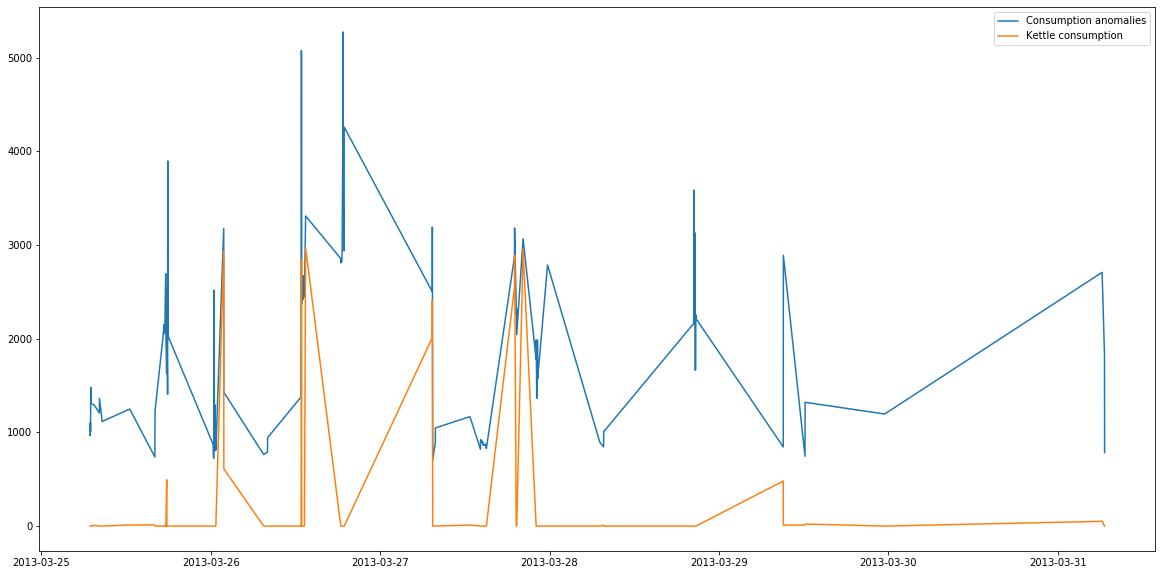

In [230]:
plt.figure(figsize=(20,10))
plt.plot(anomalies.iloc[400:600], label="Consumption anomalies")
plt.plot(kettle_anomaly.iloc[400:600], label="Kettle consumption")
plt.legend()